#### Smart Home Data [source](https://www.kaggle.com/code/offmann/smart-home-dataset/input)

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/HomeC.csv")
df.head()

c:\Users\phuro\anaconda3\envs\dsc80\lib\site-packages\IPython\core\interactiveshell.py:3505: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [3]:
df.isna().sum().sort_values(ascending=False).head(1)

Microwave [kW]    1
dtype: int64

In [4]:
df.shape

(503911, 32)

In [5]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

#### Data preprocessing

In [6]:
# Rename columns to remove spaces and the kW unit 
df.columns = [col[:-5].replace(' ','_') if 'kW' in col else col for col in df.columns]

# Drop rows with nan values 
df = df.dropna()

# The columns "use" and "house_overall" are the same, so let's remove the 'house_overall' column
df.drop(['House_overall'], axis=1, inplace=True)

# The columns "gen" and "solar" are the same, so let's remove the 'solar' column
df.drop(['Solar'], axis=1, inplace=True)

# drop rows with cloudCover column values that are not numeric (bug in sensors) and convert column to numeric
df = df[df['cloudCover']!='cloudCover']
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

# Create columns that regroup kitchens and furnaces 
df['kitchen'] = df['Kitchen_12'] + df['Kitchen_14'] + df['Kitchen_38']
df['Furnace'] = df['Furnace_1'] + df['Furnace_2']

# Convert "time" column (which is a unix timestamp) to a Y-m-d H-M-S 
import time 
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df['time'].iloc[0])))
time_index = pd.date_range(start_time, periods=len(df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

In [7]:
# Helpful functions

# lower first letter of a string  
func = lambda s: s[:1].lower() + s[1:] if s else ''

# Remove rows with values that appear less than a certain percentage %
def remove_less_percent(col, percent):
    keys_to_conserve = [key for key,value in df[col].value_counts(normalize=True).items() if value>=percent]
    return df[df[col].isin(keys_to_conserve)]


In [8]:
cols = list(df.dtypes.keys())
categ_cols = [col for col in cols if df[col].dtype=='O']
num_cols = [col for col in cols if col not in categ_cols]
print('categ_cols : ', categ_cols)
print('num_cols : ', num_cols)

categ_cols :  ['icon', 'summary']
num_cols :  ['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office', 'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14', 'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'kitchen', 'Furnace']


In [9]:
print(len(df))
df = remove_less_percent('summary', 0.05)
print(len(df))
df = remove_less_percent('icon', 0.05)
print(len(df))

503852
466308
466308


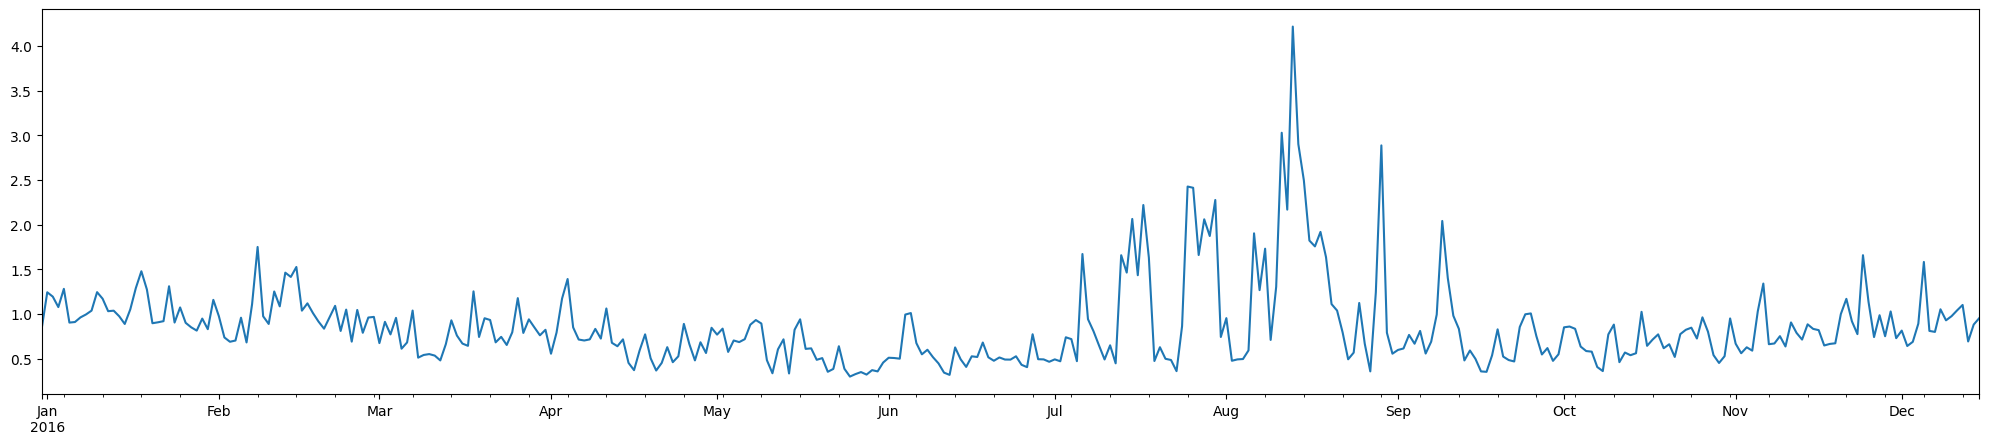

In [14]:
df['use'].resample(rule='D').mean().plot(figsize=(25,5));

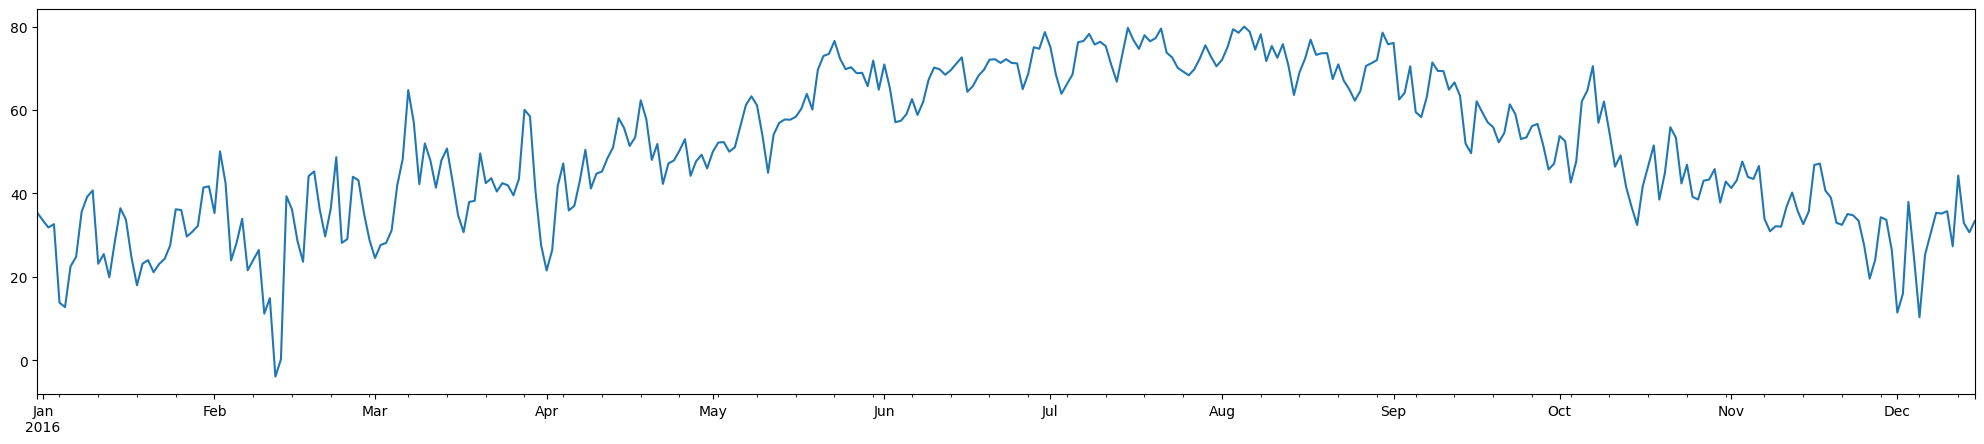

In [12]:
df['temperature'].resample(rule='D').mean().plot(figsize=(25,5));

<AxesSubplot:>

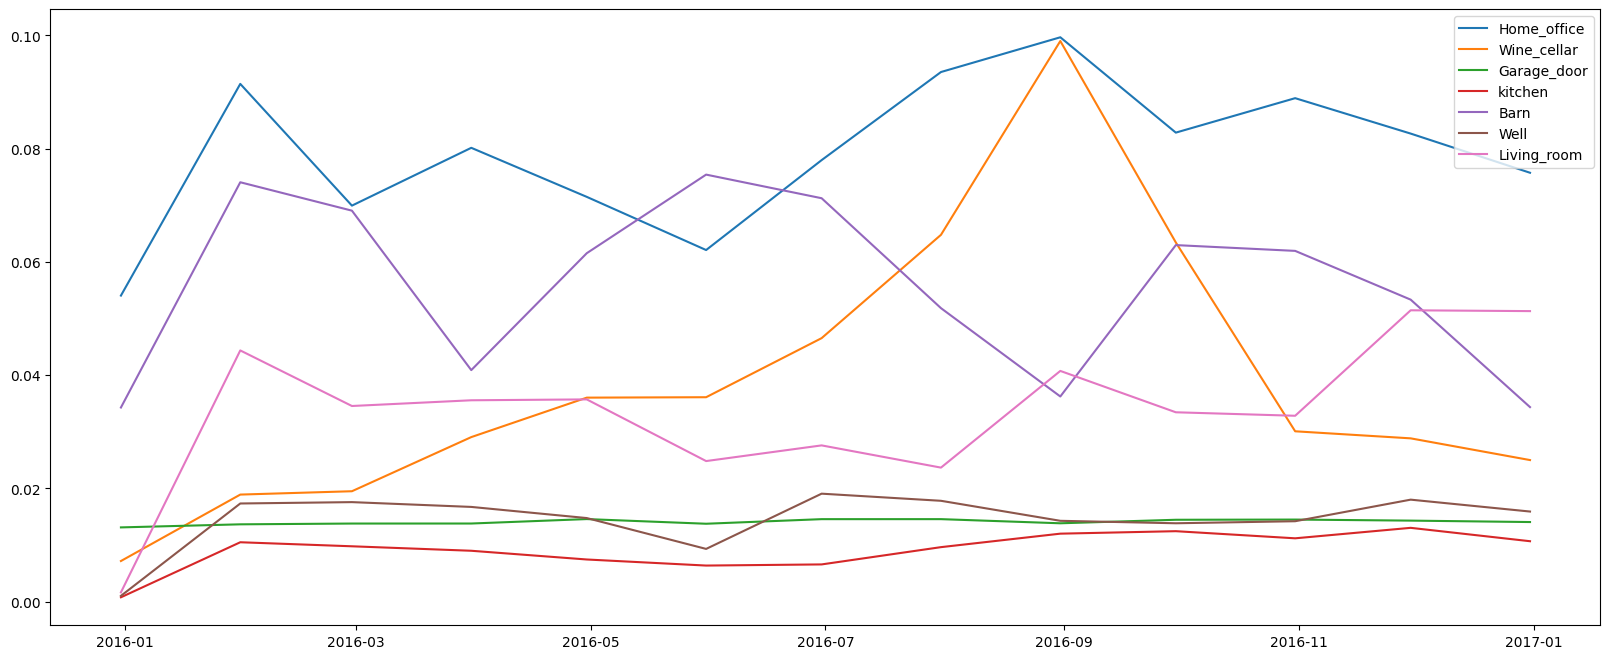

In [ ]:
rooms_energy_cols = ['Home_office', 'Wine_cellar','Garage_door',
                       'kitchen', 'Barn', 'Well','Living_room']

rooms_energy_per_month = df[rooms_energy_cols].resample('M').mean()   

plt.figure(figsize=(20,8))

sns.lineplot(data=rooms_energy_per_month, dashes=False);

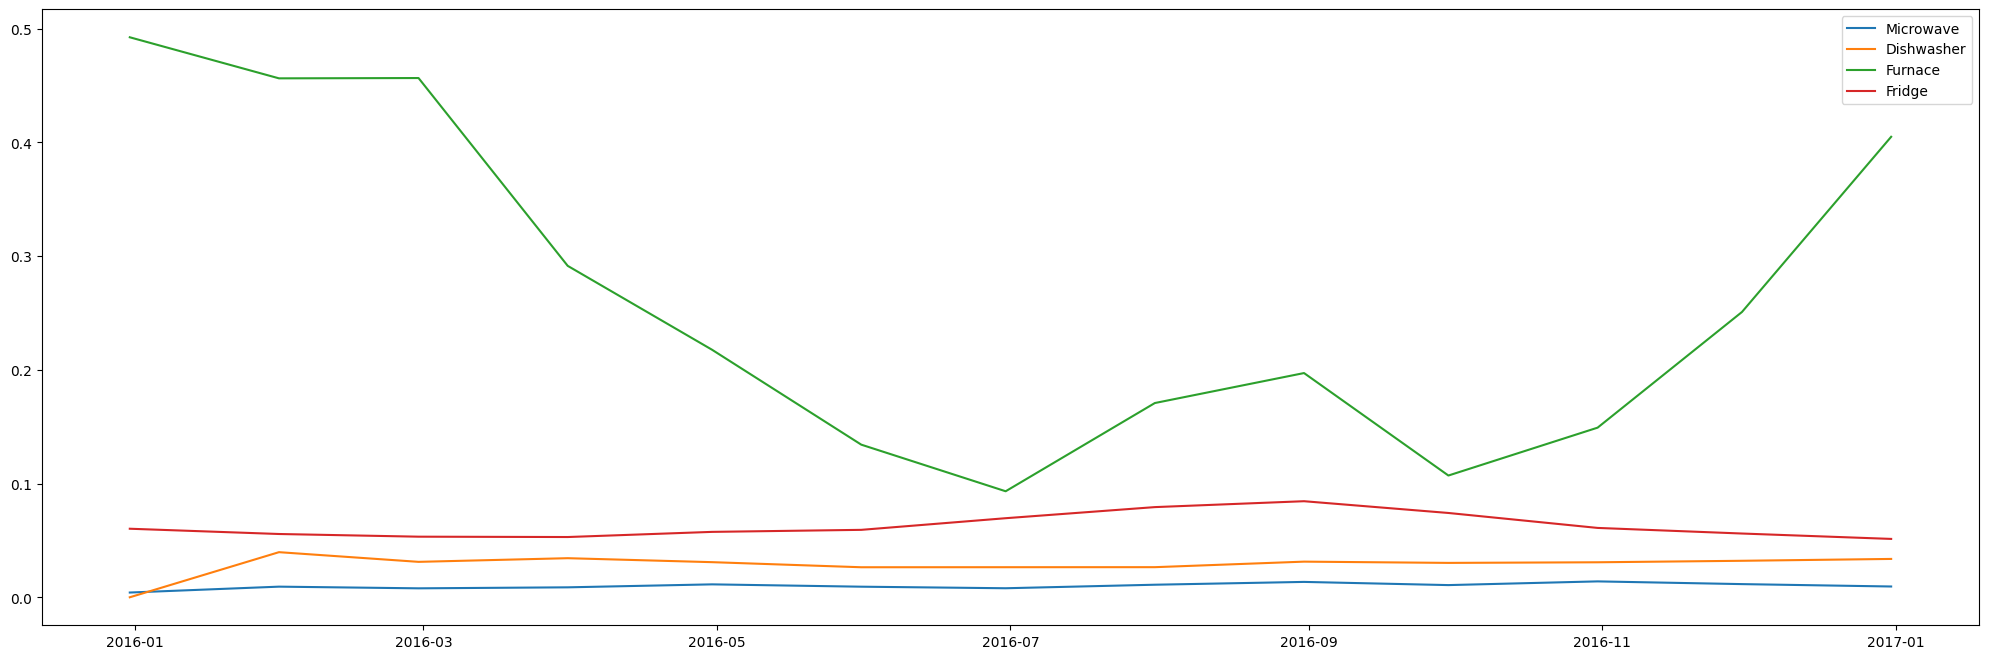

In [21]:
equipements_cols = ['Microwave', 'Dishwasher', 'Furnace', 'Fridge'] 

equipements_energy_per_month = df[equipements_cols].resample('M').mean()   

plt.figure(figsize=(25,8))

sns.lineplot(data= equipements_energy_per_month, dashes=False);

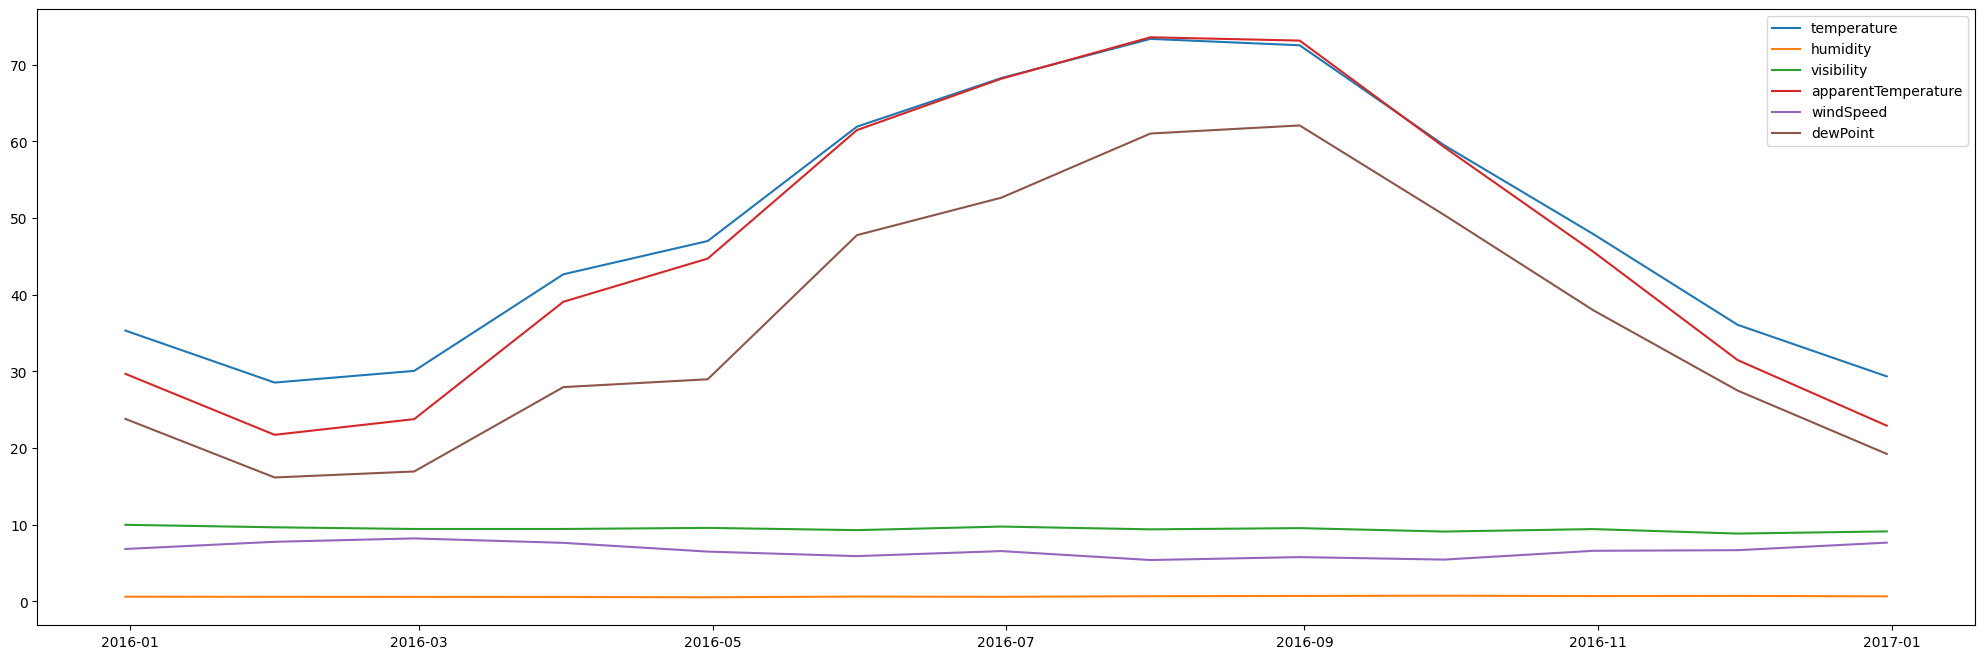

In [22]:
weather_columns = ['temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']

weather_per_month = df[weather_columns].resample('M').mean()   

plt.figure(figsize=(25,8))

sns.lineplot(data=weather_per_month, dashes=False);

#### Problem:  

1. Change Detection : Detecting excessive energy consumption in advance and preventing increase in usage fees.

1. Utility Bill Explanation : Segment systems using energy to identify source(s) of bill increases and pain points.

1. <i>(unpreferred but is an option)</i> Predict Future Consumption : Predicting future energy consumption and generation by utilizing weather information and optimizing energy supply.